## FCN

### 方法一

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
# 定义 FCN 模型

class FCN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))
        x = self.gap(x)  # Global Average Pool全局平均池化
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### 方法二

In [3]:
# Define the FCN model
'''
class FCN(nn.Module):
  def __init__(self, num_classes=4):
    super(FCN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv6 = nn.Conv2d(512, 1024, 3, padding=1)
    self.conv7 = nn.Conv2d(1024, 2048, 3, padding=1)
    self.conv8 = nn.Conv2d(2048, num_classes, 1)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.relu(self.conv5(x))
    x = nn.functional.relu(self.conv6(x))
    x = nn.functional.relu(self.conv7(x))
    x = self.conv8(x)
    return x
'''

'\nclass FCN(nn.Module):\n  def __init__(self, num_classes=4):\n    super(FCN, self).__init__()\n    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)\n    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)\n    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)\n    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)\n    self.conv5 = nn.Conv2d(256, 512, 3, padding=1)\n    self.conv6 = nn.Conv2d(512, 1024, 3, padding=1)\n    self.conv7 = nn.Conv2d(1024, 2048, 3, padding=1)\n    self.conv8 = nn.Conv2d(2048, num_classes, 1)\n\n  def forward(self, x):\n    x = nn.functional.relu(self.conv1(x))\n    x = nn.functional.relu(self.conv2(x))\n    x = nn.functional.relu(self.conv3(x))\n    x = nn.functional.relu(self.conv4(x))\n    x = nn.functional.relu(self.conv5(x))\n    x = nn.functional.relu(self.conv6(x))\n    x = nn.functional.relu(self.conv7(x))\n    x = self.conv8(x)\n    return x\n'

In [4]:
def train_epoch(net, data_loader, device):

    net.train() # 指定当前为训练模式
    train_batch_num = len(data_loader) # 记录共有多少个batch
    total_loss = 0 # 记录Loss
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0 # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data = data.to(device).float()
        # 将图片标签放入指定的device中
        target = target.to(device).long()
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        output = net(data)
        # 计算损失
        loss = criterion(output, target)
        # 进行反向传播
        loss.backward()
        optimizer.step()
        # 累加Loss
        total_loss += loss.item()
        # 找出每个样本值最大的idx，即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        # 统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        # 累加当前的样本总数
        sample_num += len(prediction)
    # 计算平均的loss与准确率
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

In [5]:
def test_epoch(net, data_loader, device):
    net.eval() # 指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [6]:
# 创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, datatxt, transform=None, target_transform=None):  # 初始化一些需要传入的参数

        fh = open(root + datatxt, 'r')  # 按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []  # 创建一个名为img的空列表，一会儿用来装东西
        for line in fh:  # 按行循环txt文本中的内容
            line = line.rstrip()       # 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            words = line.split()  # 通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            # 把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定
            imgs.append((words[0]+' '+words[1], int(words[2])))
            # 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是label
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):  # 这个方法是必须要有的，用于按照索引读取每个元素的具体内容
        # fn是图片path #fn和label分别获得imgs[index]也即是刚才每行中word[0]和word[1]的信息
        fn, label = self.imgs[index]
        # 按照path读入图片from PIL import Image # 按照路径读取图片
        img = Image.open(rootMirror+fn).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)  # 是否进行transform
        return img, label  # return很关键，return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容

    def __len__(self):  # 这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)


# 根据自己定义的MyDataset来创建数据集！注意是数据集！而不是loader迭代器
root = 'D:\\CS第四学期课程\\毕业设计\\代码\\data\\'
rootMirror = 'D:\\CS第四学期课程\\毕业设计\\代码\\data\\backup\\smaller32\\'
train_data = MyDataset(root, datatxt='train.txt',
                       transform=transforms.ToTensor())
test_data = MyDataset(root, datatxt='test.txt',
                      transform=transforms.ToTensor())
print("妥了")

classes = ('1', '2', '3', '4')
num_classes = 16  # 共4类
epochs = 100  # 训练多少轮
lr = 0.001  # 学习率
batch_size = 4  # batch大小
# device = torch.device("cuda:0") # 指定device为0号GPU,若使用cpu则填写 "cpu"
device = torch.device("cpu")
# 生成dataloader
my_trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=0)
my_testloader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=0)


妥了


In [7]:
# 初始化模型
net = FCN(4).to(device)
# 使用多元交叉熵损失
criterion = nn.CrossEntropyLoss()
# 使用Adam优化器
optimizer = optim.Adam(net.parameters(), lr=lr)


In [8]:
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 进行训练
for epoch in range(epochs):
    # 在训练集上训练
    train_loss, train_acc = train_epoch(net, data_loader=my_trainloader, device=device)
    # 在测试集上验证
    test_loss, test_acc = test_epoch(net, data_loader=my_testloader, device=device)
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc:{train_acc} \t"
          f"test_loss:{test_loss:.4f} \t test_acc:{test_acc}")

epoch:0	 train_loss:0.6330 	train_acc:0.7381776239907728 	test_loss:0.3122 	 test_acc:0.865047233468286
epoch:1	 train_loss:0.2502 	train_acc:0.8872549019607843 	test_loss:0.2661 	 test_acc:0.893387314439946
epoch:2	 train_loss:0.2078 	train_acc:0.9132064590542099 	test_loss:0.2111 	 test_acc:0.9163292847503374
epoch:3	 train_loss:0.1707 	train_acc:0.9253171856978085 	test_loss:0.1822 	 test_acc:0.9163292847503374
epoch:4	 train_loss:0.1647 	train_acc:0.932237600922722 	test_loss:0.2180 	 test_acc:0.9136302294197031
epoch:5	 train_loss:0.1521 	train_acc:0.9348327566320646 	test_loss:0.1913 	 test_acc:0.9163292847503374
epoch:6	 train_loss:0.1426 	train_acc:0.9391580161476355 	test_loss:0.2226 	 test_acc:0.9149797570850202
epoch:7	 train_loss:0.1269 	train_acc:0.9455017301038062 	test_loss:0.1873 	 test_acc:0.9298245614035088
epoch:8	 train_loss:0.1307 	train_acc:0.9478085351787774 	test_loss:0.1520 	 test_acc:0.9257759784075573
epoch:9	 train_loss:0.1148 	train_acc:0.9504036908881199 	

In [9]:
res = [train_loss_list, train_acc_list, test_loss_list,test_acc_list]

In [10]:
with open('FCN.pkl', 'wb') as f:
    pickle.dump(res, f)

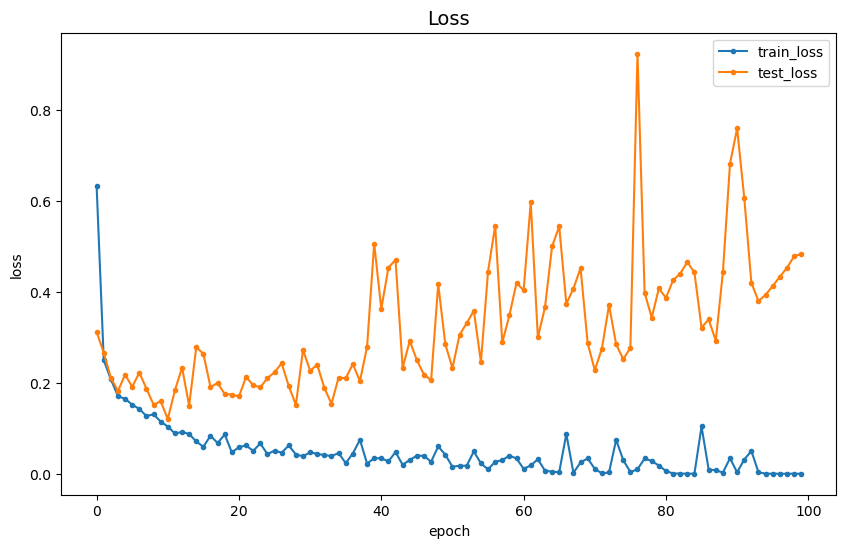

In [11]:
plt.figure(figsize=(10, 6))
train, = plt.plot(train_loss_list,'.-',label='train_loss')
test, = plt.plot(test_loss_list,'.-',label='test_loss')
plt.title("Loss",fontsize=14)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend([train,test],["train_loss", "test_loss"],loc='upper right')
plt.show()

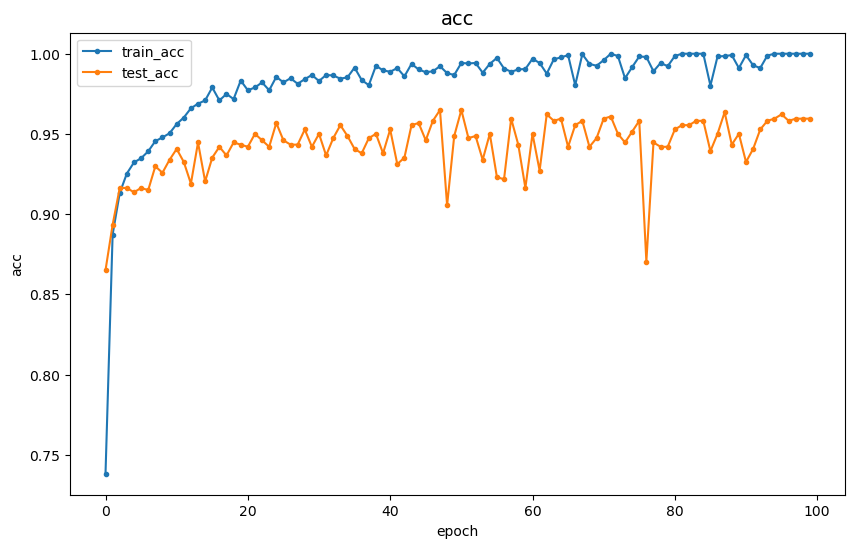

In [12]:
plt.figure(figsize=(10, 6))
train, = plt.plot(train_acc_list,'.-',label='train_acc')
test, = plt.plot(test_acc_list,'.-',label='test_acc')
plt.title("acc",fontsize=14)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend([train,test],["train_acc", "test_acc"],loc='upper left')
plt.show()

In [13]:
max(test_acc_list)

0.9649122807017544